**CLASSIFICATION**

Welcome dear reader. In this jupyter-notebook, you will meet the classification of nothing less but glass. Have you ever wondered about how a computer would classify your bedroom window? Wonder no more!

In [99]:
# imports
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from toolbox_02450 import rocplot, confmatplot
import pandas as pd
from sklearn import model_selection
import torch
import time

font_size = 15
plt.rcParams.update({'font.size': font_size})

In [100]:
# loading data
filename = 'data/glass.csv'
df = pd.read_csv(filename)

# defining x and y for the linear regression
#       all attributes except RI
X = np.array(df.iloc[:,1:10])
#       number of attributes
M = 9
#       type
y = np.array(df.iloc[:,10])

In [101]:
# the format of C needs to be this, so it is usable with torch, see before and after:
print(y)
y[y>3] = y[y>3] - 1
y = y - 1
print(y)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 5 5 5 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6
 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


In [105]:
# K = K_outer = K_inner
K = 10
CV_outer = model_selection.KFold(n_splits=K,shuffle=True)

#* INIT FOR LOGISTIC REGRESSION
# init for lambda-inner-loop
lambda_interval = np.logspace(-8, 2, 10)


#* INIT FOR STATISTICAL DATA
n_list = np.zeros(10)
mc_nemar = []
variance = np.zeros(10)


# init for error save
log_train_error = np.zeros(10)
log_test_error = np.zeros(10)

opt_lambda = np.zeros(10)
#coefficient_norm = np.zeros(len(lambda_interval))


#* INIT FOR BASE-LINE
base_line_train_err = np.zeros(10)
base_line_test_err = np.zeros(10)

#* INIT FOR ANN-CLASSIFICATION
max_iter = 10000
tolerance = 1e-6
logging_frequency = 1000
best_final_loss = 1e100
n_replicates = 1
ANN_error_test = np.zeros(K)
ANN_error_train = np.zeros(K)

h = [i for i in range(1,11)]

C = len(np.unique(y))

opt_h = np.zeros(10)


# init for time taking OPTIONAL

time_after_print = 0
time_elapsed = 0
#* OUTER LOOP
for m, (train_index, test_index) in enumerate(CV_outer.split(X,y)):
    X_train, X_test = X[train_index, :], X[test_index, :]
    y_train, y_test = y[train_index], y[test_index]

    n_list[m] = len(y_test)

    # TODO: CHECK IF THIS STANDARDIZATION IS CORRECT.
    mu = np.mean(X_train, axis=0)
    sigma = np.std(X_train, axis = 0)

    X_train = (X_train - mu)/sigma
    X_test = (X_test - mu)/sigma

    #init for optimal h
    h_error_train = np.zeros((K,len(h)))
    h_error_test = np.zeros((K,len(h)))

    #init for optimal lambda
    lambda_error_train = np.zeros((K,len(lambda_interval)))
    lambda_error_test = np.zeros((K,len(lambda_interval)))

    #* INNER LOOP
    ## ## GOAL: finding best lambda & finding best number of hidden neurons
    CV_inner = model_selection.KFold(n_splits=K,shuffle=True)
    for j, (train_index_inner, test_index_inner) in enumerate(CV_inner.split(X_train, y_train)):
        # printing
        
        time_before_print = time.time()
        time_difference = time_before_print - time_after_print
        if (j == 0) & (m == 0):
            time_difference = 0
        time_elapsed += time_difference
        
        print("outer_loop: " + str(m+1) + "/10. inner_loop: " + str(j+1) + "/10.  Time pr. iteration: " + str(round(time_difference)) + \
            " sec. Estimated time left: " + str(round((100*time_difference - time_elapsed)/60)) + str(" min."),end='\r')

        time_after_print = time.time()





        X_train_inner, X_test_inner = X_train[train_index_inner, :], X_train[test_index_inner, :]
        y_train_inner, y_test_inner = y_train[train_index_inner], y_train[test_index_inner]

        

        ##########################
        #* Finding the best lambda:
        # iterate over hyperparameter lambda
        for k in range(0, len(lambda_interval)):
            #'newton-cg' gives better results
            mdl = LogisticRegression(penalty='l2', solver='newton-cg', C=1/lambda_interval[k], max_iter=100)
            # but the other is faster but outputs hella lot of warnings:
            # mdl = LogisticRegression(penalty='l2', C=1/lambda_interval[k], max_iter=100)
            
            mdl.fit(X_train_inner, y_train_inner)

            y_train_est_inner = mdl.predict(X_train_inner).T
            y_test_est_inner = mdl.predict(X_test_inner).T
            
            lambda_error_train[j,k] = np.sum(y_train_est_inner != y_train_inner) / len(y_train_inner)
            lambda_error_test[j,k] = np.sum(y_test_est_inner != y_test_inner) / len(y_test_inner)

            # føler ikke det her skal bruges
            #w_est = mdl.coef_[0] 
            #coefficient_norm[k] = np.sqrt(np.sum(w_est**2))


        #* Finding the optimal amount of hidden layers:
        X_train_inner, X_test_inner = torch.tensor(X_train_inner, dtype=torch.float), torch.tensor(X_test_inner, dtype=torch.float)
        y_train_inner, y_test_inner = torch.tensor(y_train_inner), torch.tensor(y_test_inner)
        # reshaping helps torch
        #y_test_inner = torch.reshape(y_test_inner, (y_test_inner.shape[0],1))
        #y_train_inner = torch.reshape(y_train_inner, (y_train_inner.shape[0],1))


        # iterate over hyperparameter h
        for p, hidden_value_ in enumerate(h):
            # define the model for each hidden layer
            model_inner = lambda: torch.nn.Sequential(
                        torch.nn.Linear(M, hidden_value_), #M features to H hiden units
                        # 1st transfer function, either Tanh or ReLU:
                        #torch.nn.Tanh(),                            
                        torch.nn.ReLU(),
                        torch.nn.Linear(hidden_value_, C),
                        torch.nn.Softmax(dim=1)) #softmax as we want classes

            # loss function for multinomial classification
            loss_fn = torch.nn.CrossEntropyLoss()


            # Training the model
            for r in range(n_replicates):
                net_inner = model_inner()

                torch.nn.init.xavier_uniform_(net_inner[0].weight)
                torch.nn.init.xavier_uniform_(net_inner[2].weight)

                optimizer = torch.optim.Adam(net_inner.parameters())

                learning_curve = []
                old_loss = 1e6
                for i in range(max_iter):
                    y_est = net_inner(X_train_inner)
                    #y_class = torch.max(y_est, dim=1)[1]
                    loss = loss_fn(y_est, y_train_inner)
                    loss_value = loss.data.numpy()
                    learning_curve.append(loss_value)


                    p_delta_loss = np.abs(loss_value - old_loss)/old_loss
                    if p_delta_loss < tolerance: break
                    old_loss = loss_value


                    #if (i != 0) & ((i+1) % logging_frequency == 0):
                    #    print_str = '\t\t' + str(i+1) + '\t' + str(loss_value) + '\t' + str(p_delta_loss)
                    #    print(print_str)
                    optimizer.zero_grad(); loss.backward(); optimizer.step()


            softmax_logits = net_inner(X_test_inner)
            y_test_est = (torch.max(softmax_logits, dim=1)[1]).data.numpy() 
            h_error_test[j, p]  = np.sum(y_test_est != np.array(y_test_inner))/len(y_test_inner)



    #* Optimal values found from inner loop
    #  the smallesst of the means of the differnet lambdas
    opt_lambda[m] = lambda_interval[np.argmin(np.mean(lambda_error_test,axis=0))]
    
    opt_h[m] = h[np.argmin(np.mean(h_error_test, axis = 0))]


    #* CLASSIFICATION
    ##########################
    ## BASELINE
    # find out which class has the highest count
    big_class = np.argmax([np.count_nonzero(y_train == i) for i in range(1,7)])
    # assign everything to this class (calculate error rate)
    base_line_train_err[m] = np.sum(y_train != big_class)/len(y_train)
    base_line_test_err[m] = np.sum(y_test != big_class)/len(y_test)


    ##########################
    ## Logistic Regression
    log = LogisticRegression(penalty='l2', C=1/opt_lambda[m], max_iter=1000)
    log.fit(X_train, y_train)
    y_train_est = log.predict(X_train)
    y_test_est_log = log.predict(X_test)

    log_train_error[m] = np.sum(y_train_est != y_train)/len(y_train)
    log_test_error[m] = np.sum(y_test_est_log != y_test)/len(y_test)

    ##########################
    ## ANN-Classification

    model = lambda: torch.nn.Sequential(
                    torch.nn.Linear(M, int(opt_h[m])), #M features to H hiden units
                    # 1st transfer function, either Tanh or ReLU:
                    #torch.nn.Tanh(),                            
                    torch.nn.ReLU(),
                    torch.nn.Linear(int(opt_h[m]),int(opt_h[m])),
                    torch.nn.ReLU(),
                    torch.nn.Linear(int(opt_h[m]), C), # H hidden units to 1 output neuron
                    torch.nn.Softmax(dim=1) # final tranfer function
                    )


    X_train, y_train = torch.tensor(X_train, dtype = torch.float), torch.tensor(y_train)
    X_test, y_test = torch.tensor(X_test, dtype = torch.float), torch.tensor(y_test)
    n_replicates = 3
    for r in range(n_replicates):
        net = model()

        torch.nn.init.xavier_uniform_(net[0].weight)
        torch.nn.init.xavier_uniform_(net[2].weight)

        optimizer = torch.optim.Adam(net.parameters())

        learning_curve = []
        old_loss = 1e6
        for i in range(max_iter):
            y_est = net(X_train)
            #y_class = torch.max(y_est, dim=1)[1]
            loss = loss_fn(y_est, y_train)
            loss_value = loss.data.numpy()
            learning_curve.append(loss_value)


            p_delta_loss = np.abs(loss_value - old_loss)/old_loss
            if p_delta_loss < tolerance: break
            old_loss = loss_value


            # if (i != 0) & ((i+1) % logging_frequency == 0):
                #print_str = '\t\t' + str(i+1) + '\t' + str(loss_value) + '\t' + str(p_delta_loss)
                ###print(print_str)
            optimizer.zero_grad(); loss.backward(); optimizer.step()

        

        #print('\t\tFinal Loss:')
        #print_str = '\t\t' + str(i+1) + '\t' + str(loss_value) + '\t' + str(p_delta_loss)
        ##print(print_str)

        if loss_value < best_final_loss:
            best_net = net
            best_final_loss = loss_value
            best_learning_curve = learning_curve
        
    
    softmax_logits = net(X_test)
    y_test_est_ann = (torch.max(softmax_logits, dim=1)[1]).data.numpy() 
    ANN_error_test[m] = np.sum(y_test_est_ann != np.array(y_test))/len(y_test)

    ## STATISTICAL DATA
    ##MCNEMAR DATA
    data = np.array([y_test, y_test_est_ann, y_test_est_log, (y_test == big_class)])
    mc_nemar.append(data)
    #nvm ; variance[m] = np.var(x_test)
    # (y_test)
    # (y_test_est_ann)
    # (y_test_est_log)
    # (y_test == big_class)

# WARNING: Inden du kligger på den flotte trekant.
# Det tager cirka 145 min

/Users/nikolaj/opt/anaconda3/envs/AndSem/lib/python3.8/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


/var/folders/k7/4m0jgf1s5rggf6q996sfswf00000gn/T/ipykernel_45377/4069038626.py:268: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  data = np.array([y_test, y_test_est_ann, y_test_est_log, (y_test == big_class)])
/var/folders/k7/4m0jgf1s5rggf6q996sfswf00000gn/T/ipykernel_45377/4069038626.py:268: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = np.array([y_test, y_

/var/folders/k7/4m0jgf1s5rggf6q996sfswf00000gn/T/ipykernel_45377/4069038626.py:268: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  data = np.array([y_test, y_test_est_ann, y_test_est_log, (y_test == big_class)])
/var/folders/k7/4m0jgf1s5rggf6q996sfswf00000gn/T/ipykernel_45377/4069038626.py:268: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = np.array([y_test, y_

/var/folders/k7/4m0jgf1s5rggf6q996sfswf00000gn/T/ipykernel_45377/4069038626.py:268: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  data = np.array([y_test, y_test_est_ann, y_test_est_log, (y_test == big_class)])
/var/folders/k7/4m0jgf1s5rggf6q996sfswf00000gn/T/ipykernel_45377/4069038626.py:268: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = np.array([y_test, y_

/var/folders/k7/4m0jgf1s5rggf6q996sfswf00000gn/T/ipykernel_45377/4069038626.py:268: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  data = np.array([y_test, y_test_est_ann, y_test_est_log, (y_test == big_class)])
/var/folders/k7/4m0jgf1s5rggf6q996sfswf00000gn/T/ipykernel_45377/4069038626.py:268: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = np.array([y_test, y_

KeyboardInterrupt: 

In [103]:
print("{:<15} | {:<15} {:<15} {:<15} {:<15} {:<15}".format('Outer fold i', 'h', 'E_ANN', 'lambda', 'E_log', 'E_base'))
print("-----------------------------------------------------------------------------------------")
for i in range(10):
    print("{:<15} | {:<15} {:<15.3f} {:<15.6f} {:<15.3f} {:<15.7f}".format(i+1, int(opt_h[i]), ANN_error_test[i], opt_lambda[i], log_test_error[i], base_line_test_err[i]))


Outer fold i    | h               E_ANN           lambda          E_log           E_base         
-----------------------------------------------------------------------------------------
1               | 10              0.273           0.599484        0.273           0.7272727      
2               | 6               0.409           0.000000        0.364           0.5454545      
3               | 9               0.364           7.742637        0.409           0.5454545      
4               | 10              0.364           0.046416        0.273           0.8181818      
5               | 9               0.571           0.003594        0.333           0.7142857      
6               | 8               0.333           0.599484        0.381           0.7142857      
7               | 0               0.000           0.000000        0.000           0.0000000      
8               | 0               0.000           0.000000        0.000           0.0000000      
9               | 0         

In [45]:
n_list

array([22., 22., 22., 22., 21., 21., 21., 21., 21., 21.])

In [43]:

import pandas as pd

table = np.array([n_list, opt_h, ANN_error_test, opt_lambda, log_test_error, base_line_test_err])

df = pd.DataFrame(np.transpose(table))

df.to_csv('classification_results.csv', index = False, header = ["test_size", "h", "ANN", "lambda", "Log", "Base"])



In [1]:
plt.plot(ANN_error_test)
plt.plot(log_test_error)
plt.plot(base_line_test_err)
#plt.axhline(0.5,color='red')
plt.legend(['ANN', 'Log', 'Base'])

NameError: name 'plt' is not defined

LOOGISTIC REGRESSION (5c)

In [106]:
# Imports :
import matplotlib.pyplot as plt
#plt.style.use('fivethirtyeight')
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection

In [107]:
# loading data
filename = 'data/glass.csv'
df = pd.read_csv(filename)

# defining x and y for the linear regression
#       all attributes except RI
X = np.array(df.iloc[:,1:10])
#       number of attributes
M = 9
#       type
y = np.array(df.iloc[:,10])

In [108]:
# the format of C needs to be this, so it is usable with torch, see before and after:
print(y)
y[y>3] = y[y>3] - 1
y = y - 1
print(y)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 5 5 5 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6
 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


In [109]:
lambda_interval = np.logspace(-8, 0, 20)

max_iter = 10000


X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y,test_size=0.25, random_state=1)


# standardize
mu, sigma = np.mean(X_train), np.std(X_train)
X_train, X_test = (X_train - mu)/sigma, (X_test - mu)/sigma

# finding the best lambda (rlr validate but with logistic regression)
K_inner = 10

lambda_error_train = np.zeros((K_inner, len(lambda_interval)))
lambda_error_test = np.zeros((K_inner, len(lambda_interval)))

cv_outer = model_selection.KFold(n_splits=K_inner)


cv_inner = model_selection.KFold(n_splits=K_inner,shuffle=True)
for j, (train_index_inner, test_index_inner) in enumerate(cv_outer.split(X = X_train,y = y_train)):
    print("Inner fold:", j+1,  end="\r")
    X_train_inner, X_test_inner = X[train_index_inner, :], X[test_index_inner, :]
    y_train_inner, y_test_inner = y[train_index_inner], y[test_index_inner]

    for k in range(0, len(lambda_interval)):
        #'newton-cg' gives better results
        mdl = LogisticRegression(penalty='l2', multi_class='multinomial', tol=1e-4,\
        solver='lbfgs', C=1/lambda_interval[k], max_iter=max_iter)
        #mdl = LogisticRegression(penalty='l2', multi_class='multinomial', tol=1e-4,\
        #solver='liblinear', C=1/lambda_interval[k], max_iter=max_iter)
        # but the other is faster but outputs hella lot of warnings:
        #mdl = LogisticRegression(penalty='l2', C=1/lambda_interval[k], max_iter=max_iter)
        
        mdl.fit(X_train_inner, y_train_inner)

        y_train_est_inner = mdl.predict(X_train_inner).T
        y_test_est_inner = mdl.predict(X_test_inner).T
        
        lambda_error_train[j,k] = np.sum(y_train_est_inner != y_train_inner) / len(y_train_inner)
        lambda_error_test[j,k] = np.sum(y_test_est_inner != y_test_inner) / len(y_test_inner)

opt_lambda = lambda_interval[np.argmin(np.mean(lambda_error_test, axis = 0))]

train_err_vs_lambda = np.mean(lambda_error_train,axis=0)
test_err_vs_lambda = np.mean(lambda_error_test,axis=0)

log = LogisticRegression(penalty='l2', multi_class='multinomial', tol=1e-4,\
        solver='lbfgs', C=1/opt_lambda, max_iter=max_iter)
log.fit(X_train, y_train)
y_train_est = log.predict(X_train)
y_test_est_log = log.predict(X_test)

log_train_error = np.sum(y_train_est != y_train)/len(y_train)
log_test_error = np.sum(y_test_est_log != y_test)/len(y_test)



In [97]:
attributeNames =['Ri','Na','Mg','Al','Si','K','Ca','Ba','Fe']


for i in range(6):
    print("Weights for class: " + str(i+1))
    for l, j in enumerate(log.coef_[i]):
        print("   " + attributeNames[l] + ": " + str(j))






Weights for class: 1
   Ri: -0.43752025272368517
   Na: -0.9660000165404902
   Mg: 45.3704704012255
   Al: -56.356244998067005
   Si: 23.869196250237728
   K: 7.883844847988654
   Ca: 18.556315172817296
   Ba: 29.12849065244767
   Fe: 6.5309090099691485
Weights for class: 2
   Ri: 0.4971996392426129
   Na: -23.011898071754928
   Mg: 3.0734299786558616
   Al: -9.868065567724871
   Si: -14.146670704973035
   K: 12.63036494813368
   Ca: -0.4749393277577346
   Ba: -22.425700326918484
   Fe: 35.47182474697032
Weights for class: 3
   Ri: -1.2906866630355056
   Na: -10.960919336486219
   Mg: 20.09601188142309
   Al: -36.759708178164516
   Si: -11.216783503620231
   K: -15.370769350661325
   Ca: -2.037731057514064
   Ba: -15.957085235059859
   Fe: -2.6015520878140483
Weights for class: 4
   Ri: -0.3010242388233467
   Na: -44.777705285232464
   Mg: -33.69605865821085
   Al: 56.79834281455646
   Si: -24.036121474146295
   K: 23.65629514052577
   Ca: -7.2850057805237185
   Ba: 15.203345638110187


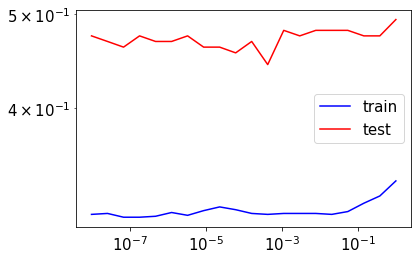

0.00042813323987193956


In [110]:
plt.loglog(lambda_interval, train_err_vs_lambda, 'b', label="train")
plt.loglog(lambda_interval, test_err_vs_lambda, 'r', label="test")
plt.legend()
plt.show()

print(lambda_interval[np.argmin(test_err_vs_lambda)])

In [67]:
attributeNames[index1:index2]

['Na', 'Mg']

In [ ]:
df.iloc[:,1]

#TEST

In [113]:


mean_vals = np.mean(X, axis=0)
std_vals = np.std(X)


standardized_data = (X-mean_vals)/std_vals

cov_matrix = np.cov(standardized_data.T)
cov_matrix

eig_val, eig_vec = np.linalg.eig(cov_matrix)

In [116]:
PCA_base = eig_vec[:,0:2]
projected_data = standardized_data@PCA_base   


In [121]:

X_train, X_test, y_train, y_test = model_selection.train_test_split(projected_data,y,test_size=0.25, random_state=1)


# standardize
mu, sigma = np.mean(X_train), np.std(X_train)
X_train, X_test = (X_train - mu)/sigma, (X_test - mu)/sigma


# finding the best lambda (rlr validate but with logistic regression)
K_inner = 10

lambda_error_train = np.zeros((K_inner, len(lambda_interval)))
lambda_error_test = np.zeros((K_inner, len(lambda_interval)))

cv_outer = model_selection.KFold(n_splits=K_inner)


cv_inner = model_selection.KFold(n_splits=K_inner,shuffle=True)
for j, (train_index_inner, test_index_inner) in enumerate(cv_outer.split(X = X_train,y = y_train)):
    print("Inner fold:", j+1,  end="\r")
    X_train_inner, X_test_inner = X[train_index_inner, :], X[test_index_inner, :]
    y_train_inner, y_test_inner = y[train_index_inner], y[test_index_inner]

    for k in range(0, len(lambda_interval)):
        #'newton-cg' gives better results
        mdl = LogisticRegression(penalty='l2', multi_class='multinomial', tol=1e-4,\
        solver='lbfgs', C=1/lambda_interval[k], max_iter=max_iter)
        #mdl = LogisticRegression(penalty='l2', multi_class='multinomial', tol=1e-4,\
        #solver='liblinear', C=1/lambda_interval[k], max_iter=max_iter)
        # but the other is faster but outputs hella lot of warnings:
        #mdl = LogisticRegression(penalty='l2', C=1/lambda_interval[k], max_iter=max_iter)
        
        mdl.fit(X_train_inner, y_train_inner)

        y_train_est_inner = mdl.predict(X_train_inner).T
        y_test_est_inner = mdl.predict(X_test_inner).T
        
        lambda_error_train[j,k] = np.sum(y_train_est_inner != y_train_inner) / len(y_train_inner)
        lambda_error_test[j,k] = np.sum(y_test_est_inner != y_test_inner) / len(y_test_inner)

opt_lambda = lambda_interval[np.argmin(np.mean(lambda_error_test, axis = 0))]

train_err_vs_lambda = np.mean(lambda_error_train,axis=0)
test_err_vs_lambda = np.mean(lambda_error_test,axis=0)

log = LogisticRegression(penalty='l2', multi_class='multinomial', tol=1e-4,\
        solver='lbfgs', C=1/opt_lambda, max_iter=max_iter)
log.fit(X_train, y_train)
y_train_est = log.predict(X_train)
y_test_est_log = log.predict(X_test)

log_train_error = np.sum(y_train_est != y_train)/len(y_train)
log_test_error = np.sum(y_test_est_log != y_test)/len(y_test)





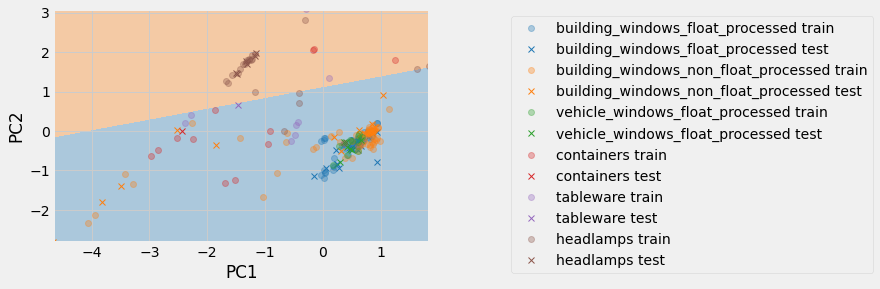

In [125]:
from toolbox_02450 import visualize_decision_boundary
plt.style.use('fivethirtyeight')
#attributeNames = [name[0] for name in mat_data['attributeNames'].squeeze()]
#classNames = [name[0][0] for name in mat_data['classNames']]

classNames = ['building_windows_float_processed', 'building_windows_non_float_processed','vehicle_windows_float_processed',\
            'containers', 'tableware', 'headlamps']
attributeNames =['Ri','Na','Mg','Al','Si','K','Ca','Ba','Fe']

index1 = 1
index2 = index1+2



log_test = LogisticRegression(penalty='l2', tol=1e-4,\
        solver='lbfgs', C=1/opt_lambda, max_iter=max_iter)
log_test.fit(X_train[index1:index2,:], y_train[index1:index2])


predict = lambda x: np.argmax(log_test.predict_proba(x),1)
visualize_decision_boundary(predict, [X_train, X_test], [y_train, y_test], ['PC1','PC2'], classNames)


In [123]:
log_test_error

0.3888888888888889